In [ ]:
# default_exp gram

# gram

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import bezier
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
import numpy as np
from penkit import write, preview
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
linebreak = np.array([[np.nan],[np.nan]])

In [ ]:
# %matplotlib inline

In [ ]:
#export
def dist_from_point(line, point):
    '''calculate euclidean distance of a set of points from a reference point'''
    return ((line - point) ** 2).sum(axis=1) ** 0.5

In [ ]:
#export
def lines_to_layer(lines):
    nanlines = []
    for line in lines:
        _line = np.concatenate([line,np.array([[np.nan, np.nan]])])
        nanlines.append(_line)
    nanlines = np.concatenate(nanlines)
    x = nanlines[:,0]
    y = nanlines[:,1]
    return (x,y)

In [ ]:
#export
def layer_to_lines(layer):
    _layer = layer[:, 1:]  # drop first column containing placeholder nan
    _layer = np.append(_layer, linebreak, axis=1)  # add linebreak to end
    isnan = np.isnan(_layer[0, :]).nonzero()[0]
    lines = []
    start_ind = 0
    for nan_ind in isnan:
        line = _layer[:, start_ind:nan_ind].T
        lines.append(line)
        start_ind = nan_ind + 1
    return lines

In [ ]:
#export
def get_point_on_line(pointA, pointB, distance):
    AB = pointB - pointA
    pointC = pointA + (AB * distance)
    return pointC

In [ ]:
#export
def radial_to_xy(r, theta):
        x = np.cos(theta) * r
        y = np.sin(theta) * r
        return (x, y)

In [ ]:
#export
def gaussian_random_walk(n, step_init=1, step_mu=0., step_std=1, scale=True):
    ys = []
    y = step_init
    if scale:
        step_mu /= n
        step_std /= n
    for i in range(n):
        ys.append(y)
        y += np.random.randn() * step_std + step_mu
    return np.array(ys)

In [ ]:
#export
class LineFactory(object):
    
    def __init__(self):
        self.lines = np.array([[np.nan],
                               [np.nan]])
        
    def gen_line(self, pointA, pointB, ):
        line = np.array([[pointA[0], pointB[0]],
                         [pointA[1], pointB[1]],
                        ])
        return line
        
    def add_line(self, line, terminate=True):
        if terminate:
            line = np.append(line, linebreak.copy(), axis=1)
        self.lines = np.append(self.lines, line, axis=1)
        
    def gen_bezier(self, nodes, bez_eval_start=0, bez_eval_end=1, n_eval_points=1000):
        nodes = np.asfortranarray(nodes)
        curve = bezier.Curve(nodes, degree=(nodes.shape[1]-1))
        eval_points = np.linspace(bez_eval_start, bez_eval_end, n_eval_points)
        x, y = curve.evaluate_multi(eval_points)
        return np.stack([x, y])
    
    def add_bezier(self, nodes, bez_eval_start=0, bez_eval_end=1, n_eval_points=1000, terminate=True):
        line = self.gen_bezier(nodes, bez_eval_start, bez_eval_end, n_eval_points)
        self.add_line(line, terminate=terminate)
        
    def flip_alternating_lines(self):
        lines = layer_to_lines(self.lines)
        new_lines = []
        for i, line in enumerate(lines):
            if i % 2:
                new_lines.append(np.flipud(line))
            else:
                new_lines.append(line)
        self.lines = np.append(linebreak, lines_to_layer(new_lines), axis=1)
         
    def plot_lines(self, ax, lc_kwargs={}):
        lc = LineCollection(layer_to_lines(self.lines), **lc_kwargs)
        ax.add_collection(lc)
        ax.axis('tight')
        ax.axis('square')

In [ ]:
#export
class ChordFactory(LineFactory):
    def __init__(self,
                 center=np.array([0.,0.]),
                 radius=1,
                ):
        self.center = center.reshape(2,1)
        self.radius = radius
        self.lines = np.array([[np.nan], [np.nan]])
        
    @property
    def center_x(self):
        return self.center[0]
    
    @property
    def center_y(self):
        return self.center[1]
    
    def gen_chord(self, theta0, theta1, radius0=None, radius1=None):
        if not radius0:
            radius0 = self.radius
        if not radius1:
            radius1 = self.radius
        x0, y0 = radial_to_xy(radius0, theta0)
        x1, y1 = radial_to_xy(radius1, theta1)
        chord = np.array([[x0, x1, np.nan],
                          [y0, y1, np.nan],
                            ])
        chord += self.center
        return chord
    
    def add_chord(self, theta0, theta1, radius0=None, radius1=None):
        chord = self.gen_chord(theta0, theta1, radius0, radius1)
        self.lines = np.append(self.lines, chord, axis=1)
    
    def gen_diameter(self, theta0, radius=None):
        if not radius:
            radius = self.radius
        theta1 = theta0 + np.pi
        return self.gen_chord(theta0=theta0,
                              theta1=theta1,
                              radius0=radius,
                              radius1=radius
                             )
        
    def add_diameter(self, theta0, radius=None):
        diameter = self.gen_diameter(theta0, radius)
        self.lines = np.append(self.lines, diameter, axis=0)
        
    def gen_bezier_chord(self,
                         thetas,
                         radii,
                         bez_eval_start=0,
                         bez_eval_end=1,
                         n_eval_points=1000
                        ):
        n = len(thetas)
        xs = np.zeros(n)
        ys = np.zeros(n)
        for i in range(n):
            theta = thetas[i]
            radius = radii[i]
            x, y = radial_to_xy(radius, theta)
            xs[i] = x
            ys[i] = y
        nodes = np.stack([xs,ys])
        line = self.gen_bezier(
                   nodes,
                   bez_eval_start=bez_eval_start,
                   bez_eval_end=bez_eval_end,
                   n_eval_points=n_eval_points)
        line = line + self.center
        return line


In [ ]:
#export
class RandomChordFactory(ChordFactory):
        
    def add_random_diameters(self, n_diameters=10):
        for theta in np.random.rand(n_diameters) * np.pi * 2:
            self.add_diameter(theta)
            
    def add_random_chords_at_set_d_theta(self, n_chords, d_theta):
            for theta0 in np.random.rand(n_chords) * np.pi * 2:
                theta1 = theta0 + d_theta
                self.add_chord(theta0=theta0, theta1=theta1)
            
    def add_connected_chords_at_set_d_theta(self, n_chords, d_theta):
        theta0 = np.random.rand() * np.pi * 2
        for i in range(n_chords):
            theta1 = theta0 + d_theta
            self.add_chord(theta0=theta0, theta1=theta1)
            theta0 = theta1
            
    def add_connected_chords_stochastic_d_theta(self,
                                                   n_chords,
                                                   d_theta_mu=0,
                                                   d_theta_std=1,
                                                  ):
        theta0 = np.random.rand() * np.pi * 2
        for i in range(n_chords):
            theta1 = theta0 + np.random.randn() * d_theta_std + d_theta_mu
            self.add_chord(theta0=theta0, theta1=theta1)
            theta0 = theta1
            
    def add_nearby_chords_stochastic(self,
                                     n_chords,
                                     theta_mu=0,
                                     theta_std=0,
                                     d_theta_mu=0,
                                     d_theta_std=0,
                                     radius_mu=0,
                                     radius_std=0,
                                    ):
        theta0 = np.random.rand() * np.pi * 2
        radius = self.radius
        for i in range(n_chords):
            theta1 = theta0 + np.random.randn() * d_theta_std + d_theta_mu
            self.add_chord(theta0=theta0, theta1=theta1, radius0=radius, radius1=radius)
            radius = radius + np.random.randn() * radius_std + radius_mu
            theta0 = theta1 + np.random.randn() * theta_std + theta_mu
            

In [ ]:
#export
class RadiusModChordFactory(ChordFactory):
    
    def __init__(self,center=np.array([0.,0.])):
        self.center = center.reshape(2,1)
        self.lines = np.array([[np.nan], [np.nan]])
        self.initialize_params()
        
    def initialize_params(self,
                            n_chords=500,
                            d_theta=np.pi*0.6,
                            start_theta=0,
                            end_theta=np.pi*2,
                            overshoot_init=1,
                            overshoot_step_mu=0.,
                            overshoot_step_std = 20,
                            ):
        self.n_chords = n_chords
        self.theta0s = np.linspace(start_theta, end_theta, n_chords)
        self.theta1s = self.theta0s + d_theta
        self.radius0s = np.ones(n_chords)
        self.radius1s = np.ones(n_chords)
        self.overshoots = gaussian_random_walk(n_chords,
                                step_init=overshoot_init,
                                step_mu=overshoot_step_mu,
                                step_std=overshoot_step_std,
                                scale=True)

        
    def plot_params(self):
        f,axs = plt.subplots(5, 1, sharex=True, figsize=(12,8))
        axs[0].plot(self.theta0s, label='theta0s')
        axs[1].plot(self.theta1s, label='theta1s')
        axs[2].plot(self.radius0s, label='radius0s')
        axs[3].plot(self.radius1s, label='radius1s')
        axs[4].plot(self.overshoots, label='overshoots')
        for ax in axs:
            ax.legend()
        
    def add_single_overshoot_chords(self):
        for i in range(self.n_chords):
            line = self.gen_chord(theta0=self.theta0s[i],
                        theta1=self.theta1s[i],
                        radius0=self.radius0s[i],
                        radius1=self.radius1s[i])
            pointA = line[:,0]
            pointB = line[:,1]
            new_pointB = get_point_on_line(pointA, pointB, self.overshoots[i])
            new_line = self.gen_line(pointA, new_pointB)
            self.add_line(new_line)
            
    def add_double_overshoot_chords(self):
        for i in range(self.n_chords):
            line = self.gen_chord(theta0=self.theta0s[i],
                        theta1=self.theta1s,
                        radius0=self.radius0s[i],
                        radius1=self.radius1s[i])
            pointA = line[:,0]
            pointB = line[:,1]
            new_pointB = get_point_on_line(pointA, pointB, self.overshoots[i])
            new_pointA = get_point_on_line(pointB, pointA, self.overshoots[i])
            new_line = self.gen_line(pointA, new_pointB)
            self.add_line(line)
            
    

In [ ]:
#export
class RadiusModBezierChordFactory(ChordFactory):
    
    def __init__(self,center=np.array([0.,0.])):
        self.center = center.reshape(2,1)
        self.lines = np.array([[np.nan], [np.nan]])
        self.initialize_params()
        
    def initialize_params(self,
                            n_chords=500,
                            d_theta=np.pi*0.6,
                            start_theta=0,
                            end_theta=np.pi*2,
                            middle_node_rel_thetas=[0.5,],
                            overshoot_init=1,
                            overshoot_step_mu=0.,
                            overshoot_step_std = 20,
                            ):
        self.n_chords = n_chords
        chord_start_thetas = np.linspace(start_theta, end_theta, n_chords)
        chord_end_thetas = chord_start_thetas + d_theta
        middle_nodes = []
        for node_rel_theta in middle_node_rel_thetas:
            middle_nodes.append(chord_start_thetas + d_theta * node_rel_theta)
        self.thetas = np.stack([chord_start_thetas,] + middle_nodes + [chord_end_thetas,]).T
        self.radii = np.ones(self.thetas.shape)
        self.overshoots = gaussian_random_walk(n_chords,
                                step_init=overshoot_init,
                                step_mu=overshoot_step_mu,
                                step_std=overshoot_step_std,
                                scale=True)
        
    def add_single_overshoot_bezier_chords(self):
        for i in range(self.n_chords):
            _thetas = self.thetas[i, :]
            _radii = self.radii[i, :]
            overshoot = self.overshoots[i]
            line = self.gen_bezier_chord(
                         _thetas,
                         _radii,
                         bez_eval_start=0,
                         bez_eval_end=overshoot,
                         n_eval_points=1000
                        )
            self.add_line(line)
            
    def globe_params(self,
                            n_chords=500,
                            start_theta=0.,
                            end_theta=np.pi*2,
                            middle_node_rel_thetas=[0.5,],
                            overshoot_init=1,
                            overshoot_step_mu=0.,
                            overshoot_step_std = 0,
                            ):
        self.n_chords = n_chords
        chord_start_thetas = np.linspace(start_theta, end_theta, n_chords)
        chord_end_thetas = - chord_start_thetas
        middle_nodes = np.stack([chord_start_thetas,chord_end_thetas]).mean(axis=0)
        self.thetas = np.stack([chord_start_thetas, middle_nodes, chord_end_thetas,]).T
        self.radii = np.ones(self.thetas.shape)
#         self.radii[:,1] = np.linspace(1,-1,n_chords)
        self.radii[:,1] = -1
        self.overshoots = gaussian_random_walk(n_chords,
                                step_init=overshoot_init,
                                step_mu=overshoot_step_mu,
                                step_std=overshoot_step_std,
                                scale=True)

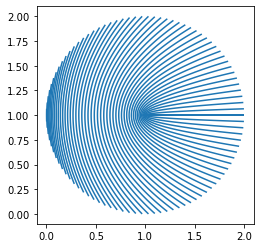

In [ ]:
f, ax = plt.subplots()
layers = []
lf = RadiusModBezierChordFactory(center = np.array([1,1]))
start_theta = 0
end_theta = start_theta + np.pi*1
lf.globe_params(
                    n_chords=50,
                    start_theta=start_theta,
                    end_theta=end_theta,
                    middle_node_rel_thetas=[0.5,],
                    overshoot_init=1,
                    overshoot_step_mu=0.0,
                    overshoot_step_std = 0,
                    )
lf.add_single_overshoot_bezier_chords()
lf.plot_lines(ax=ax)
layers.append(lf.lines)

In [ ]:
#export
class Turtle(LineFactory):
    
    def __init__(self, x=0, y=0, rad=0, pen='up'):
        self.x = x
        self.y = y
        self.rad = rad
        self.pen = pen
        super().__init__()
        
    @property
    def coord(self):
        return np.array([[self.x], [self.y]])
    
    @coord.setter
    def coord(self, new_coord):
        self.x = new_coord[0]
        self.y = new_coord[1]
        
    @property
    def degrees(self):
        return self.rad / (np.pi * 2) * 360
    
    @degrees.setter
    def degrees(self, degrees):
        self.rad = degrees / 360 * np.pi * 2
    
    @coord.setter
    def coord(self, new_coord):
        self.x = new_coord[0]
        self.y = new_coord[1]
        
    def add_point(self):
        self.lines = np.append(self.lines, self.coord, axis=1)
        
    def pen_down(self):
        self.pen = 'down'
        self.add_point()
        
    def pen_up(self):
        self.pen = 'up'
        self.lines = np.append(self.lines, linebreak.copy(), axis=1)
        
    def forward(self, d):
        self.x += np.cos(self.rad) * d
        self.y += np.sin(self.rad) * d
        if self.pen == 'down':
            self.add_point()
            
    def turn(self, d_angle, use_degrees=False):
        if use_degrees:
            new_degrees = self.degrees + d_angle
            self.degrees = new_degrees % 360
        else:
            new_rad = self.rad + d_angle
            self.rad = new_rad % (np.pi * 2)
        
    def circle(self, radius, extent=(np.pi*2), n_eval_points=1000, use_degrees=False):
        
        d_angle = extent / n_eval_points
        forward_d = 2 * radius / n_eval_points
        for n in range(n_eval_points):
            self.forward(forward_d)
            self.turn(d_angle, use_degrees=use_degrees)
    
    def split(self):
        return self.__class__(x=self.x, y=self.y, rad=self.rad, pen=self.pen)

In [ ]:
n_iter = 600
t = Turtle()
t.pen_down()
ts = [t]
choice_p = {
    'forward': 0.6,
    'turn': 0.39,
    'split': 0.01
}
choices = np.array(list(choice_p.keys()))
ps = np.array(list(choice_p.values()))

forward_dist = 1
turn_mean = 0.02
turn_std = 0.15

(-256.46863877030825,
 204.0231524855849,
 -139.09743736826294,
 334.3306451856197)

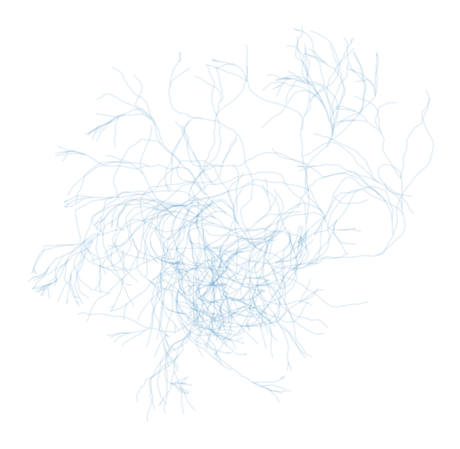

In [ ]:
for i in range(n_iter):
    for t in ts:
        choice = np.random.choice(a=choices, p=ps)
        if choice == 'forward':
            t.forward(forward_dist)
        if choice == 'turn':
            rad = np.random.randn() * turn_std + turn_mean
            t.turn(rad)
        if choice == 'split':
            ts.append(t.split())

layer = np.concatenate([t.lines for t in ts], axis=1)

f, ax = plt.subplots(figsize=(8,8))
lines = layer_to_lines(layer)
lc = LineCollection(lines, alpha=0.1)
ax.add_collection(lc)
ax.axis('tight')
ax.axis('off')

In [ ]:
t.lines

array([[      nan, 0.       , 0.       , 0.       , 1.       , 1.       ,
        1.8660254, 2.3660254],
       [      nan, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.5      , 1.3660254]])

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_gram.ipynb.
Converted 01_gram_scratch.ipynb.
Converted 02_write.ipynb.
Converted 03_quiver.ipynb.
Converted 04_graph_grams.ipynb.
Converted 05_blender_prep.ipynb.
This cell doesn't have an export destination and was ignored:
h
Converted 06_turtle_scratch.ipynb.
Converted 07_location_history_parse.ipynb.
Converted 08_location_hist_scratch.ipynb.
Converted 09_location_hist_plots.ipynb.
Converted 10_sinflower_scratch.ipynb.
Converted 11_sinflower.ipynb.
Converted index.ipynb.


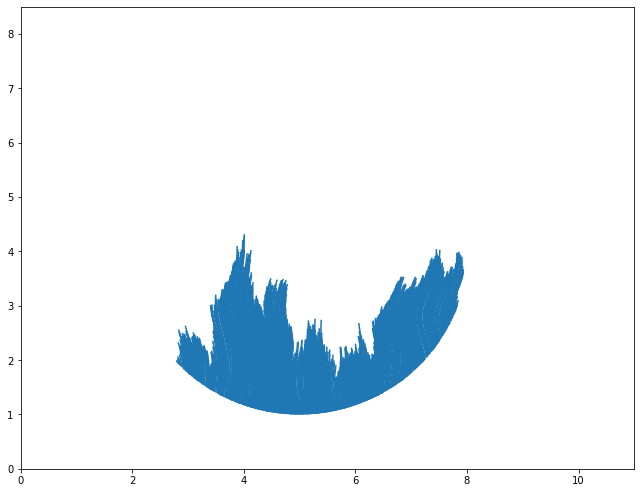

In [ ]:
lines = []

node_sets = []
n_lines = 1200
n_nodes_per_line = 20
y_start = 0.5
y_end = 5
x_start = 1
x_end = 10
node_x_centers = np.linspace(x_start, x_end, n_lines)
std_scale = 0.02
n_eval_points = 2000

### initialize vals
node_ys = np.linspace(y_start, y_end, n_nodes_per_line)
centered_node_xs = np.zeros(node_ys.shape)
bez_eval_end_center = 0.7
bez_eval_end_noise = 0
bez_eval_end_limit = 1.02
bez_eval_end_std_scale = 0.02

for i, node_x_center in enumerate(node_x_centers):
#     node_ys = np.flipud(node_ys)
#     centered_node_xs = np.flipud(centered_node_xs)
    new_x_noise = np.random.randn(n_nodes_per_line) * std_scale
    bez_eval_end_noise = bez_eval_end_noise + np.random.randn() * bez_eval_end_std_scale
    centered_node_xs = centered_node_xs + new_x_noise
    node_xs = node_x_center + centered_node_xs
    node_xs[0:3] = node_x_center
#     node_xs[-1] = node_x_center
    nodes = np.asfortranarray([
        node_xs,
        node_ys,
        ])
    curve = bezier.Curve(nodes, degree=(nodes.shape[1]-1))
    bez_eval_end = bez_eval_end_center + bez_eval_end_noise
    if bez_eval_end > bez_eval_end_limit:
        bez_eval_end = 1 + np.random.randn()*0.02
    eval_points = np.linspace(0, bez_eval_end, n_eval_points)
    x, y = curve.evaluate_multi(eval_points)
    if i % 2:
        x = np.flipud(x)
        y = np.flipud(y)
    lines.append(np.stack([x, y]).T)
    node_sets.append(np.stack([node_xs, node_ys]).T)

in_circle_lines = []
center_loc = np.array([5.,4])
circle_rad = 3
for line in lines:
    in_circle = dist_from_point(line, center_loc) < circle_rad
    in_circle_lines.append(line[in_circle,:])



    
    
lc = LineCollection(lines)
iclc = LineCollection(in_circle_lines)
ns = np.concatenate(node_sets)
plt.close('all')
f,ax = plt.subplots(figsize=(11, 8.5))
ax.set_xlim((0, 11))
ax.set_ylim((0, 8.5))

# ax.add_collection(lc)
ax.add_collection(iclc)

Converted 00_gram.ipynb.
Converted 01_gram_scratch.ipynb.
Converted index.ipynb.
